In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# from pandas.core.common import SettingWithCopyWarning
# %config InlineBackend.figure_format = "retina" # 맥북일 때 on
%matplotlib inline
warnings.simplefilter(action="ignore", category=FutureWarning)
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

D:\miniconda\envs\ml4t\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Chapter 5 - Technical Analysis and Building Interactive Dashboards

> 이 장에서는 Python을 사용한 기술적 분석(TA)의 기초를 다룹니다.

- 주요 내용

    - 가장 인기 있는 기술적 지표 계산
    - 기술적 지표 다운로드
    - 캔들스틱 패턴 인식
    - Streamlit을 사용한 기술적 분석용 대화형 웹 앱 구축
    - 기술적 분석 앱 배포

## 5.1 Calculating the most popular technical indicators

In [38]:
import pandas as pd 
import yfinance as yf
import talib

In [39]:
df = yf.download("NVDA", 
                 start="2023-09-06", 
                 end="2024-09-06",
                 progress=False,
                 auto_adjust=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-09-06,48.430490,48.538465,46.569894,47.050789,468670000
2023-09-07,45.515120,46.333943,45.142200,46.230965,433330000
2023-09-08,45.932037,46.595891,45.261181,45.562115,473069000
2023-09-11,46.137988,46.152985,44.302388,45.168201,473966000
2023-09-12,44.728292,45.663091,44.521337,44.860264,349256000
...,...,...,...,...,...
2024-08-29,121.360001,124.430000,116.709999,117.589996,453023300
2024-08-30,119.529999,121.750000,117.220001,119.370003,333751600
2024-09-03,116.010002,116.209999,107.290001,108.000000,474040800


### 1. 단순이동평균(SMA) 
SMA는 TA-Lib 라이브러리의 SMA 함수를 사용하여 계산합니다.

```
df["sma_20"] = talib.SMA(df["Close"], timeperiod=20)
```

- 일반적으로 20일 기간을 사용
- 가격 움직임의 전반적인 추세를 파악하는 데 도움

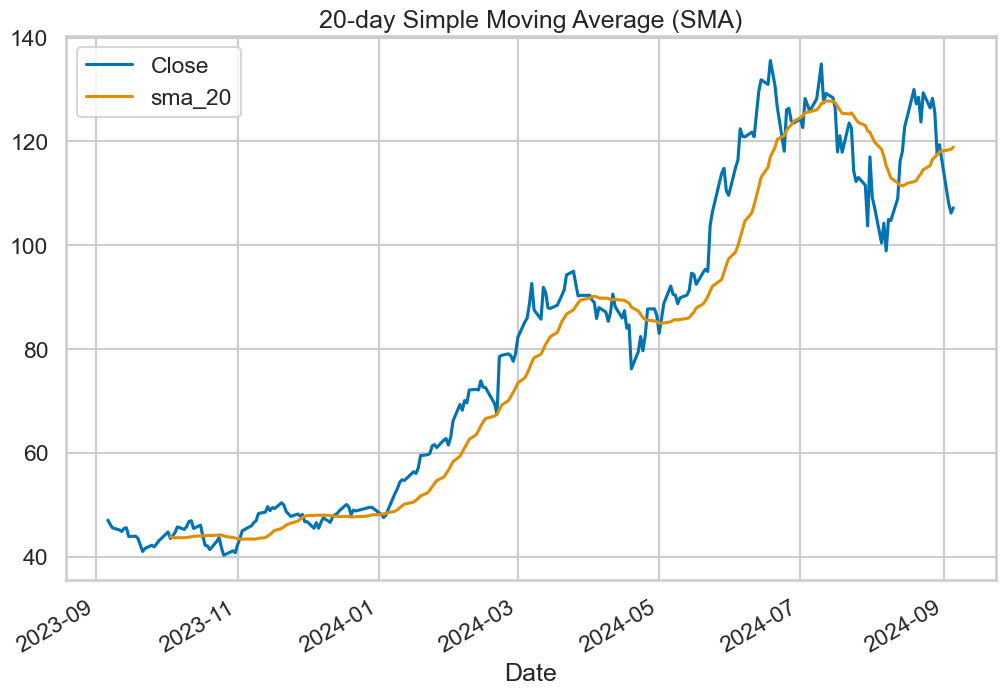

In [32]:
df["sma_20"] = df["Close"].rolling(20).mean()
df[["Close", "sma_20"]].plot(title="20-day Simple Moving Average (SMA)");

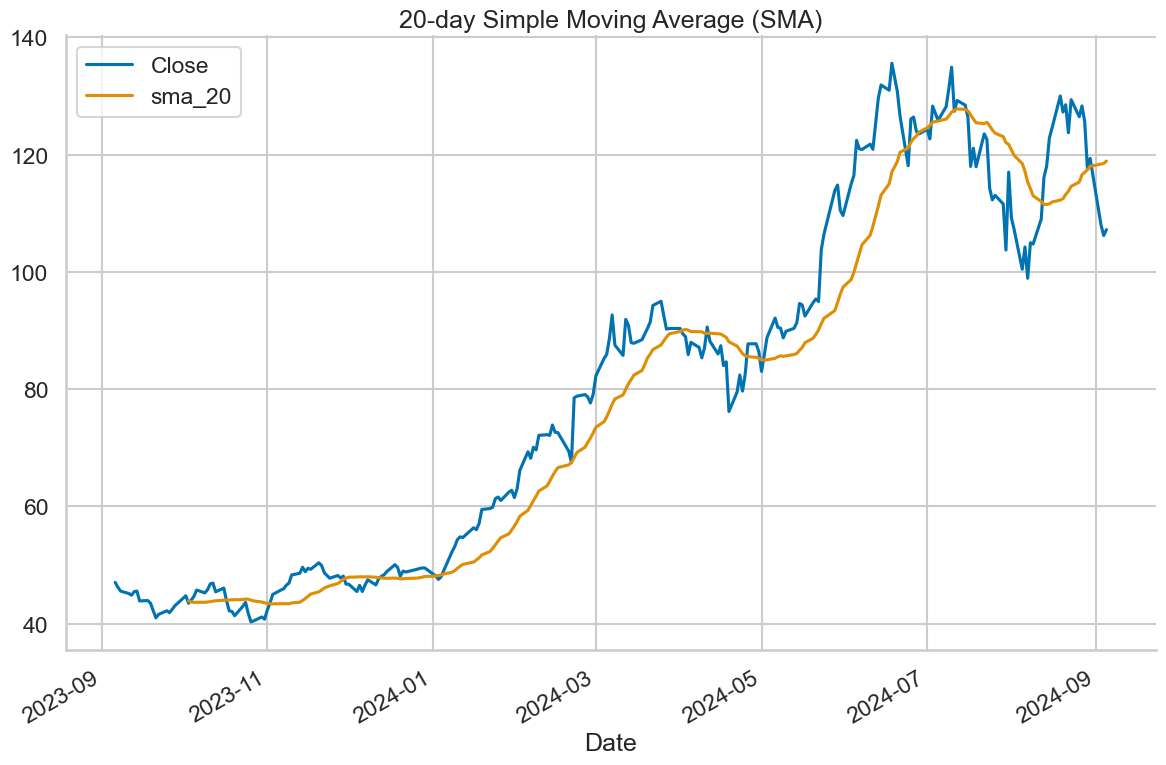

In [33]:
df["sma_20"] = talib.SMA(df["Close"], timeperiod=20)
(
    df[["Close", "sma_20"]]
    .plot(title="20-day Simple Moving Average (SMA)")
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_1", dpi=200)

### 2. 볼린저 밴드

- 가격과 변동성에 대한 정보를 제공하는 통계적 방법
```
 계산 방법:
 - 이동평균 계산 (일반적으로 20일)
 - 이동 표준편차 계산
 - 상단/하단 밴드 = 이동평균 ± (K * 이동 표준편차) (일반적으로 K=2)
```

- TA-Lib의 BBANDS 함수를 사용하여 계산
- 밴드가 넓어지면 변동성 증가, 좁아지면 변동성 감소를 의미
- 2 표준편차를 사용하는 것은 수익률의 정규분포 가정에 기반 (경험적으로는 부정확). 

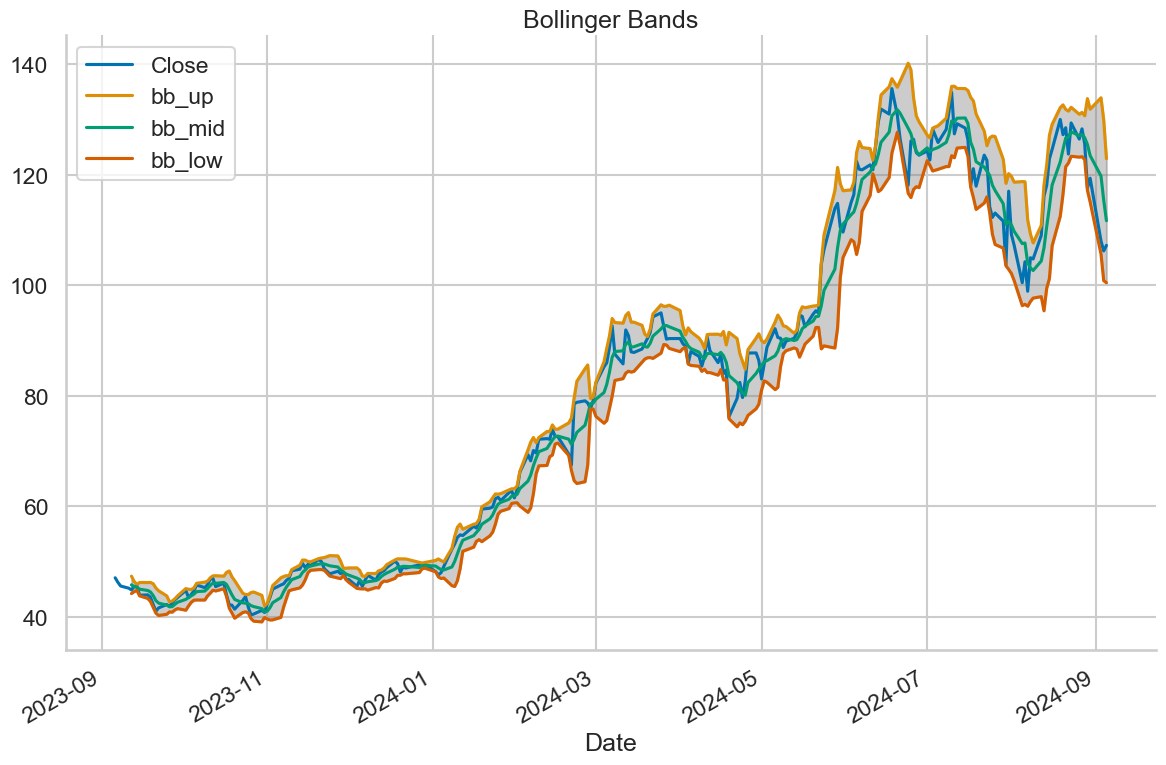

In [34]:
df["bb_up"], df["bb_mid"], df["bb_low"] = talib.BBANDS(df["Close"])

fig, ax = plt.subplots()

(
    df.loc[:, ["Close", "bb_up", "bb_mid", "bb_low"]]
    .plot(ax=ax, title="Bollinger Bands")
)

ax.fill_between(df.index, df["bb_low"], df["bb_up"], 
                color="gray", 
                alpha=.4)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_2", dpi=200)

### 3. 상대강도지수(RSI)

- 자산의 종가를 사용하여 과매수/과매도 상태를 식별합니다.
- 일반적으로 14일 기간을 사용하여 계산합니다.
- 0에서 100 사이의 값을 가집니다.
```
해석:

RSI < 30: 과매도 상태, 매수 신호
RSI > 70: 과매수 상태, 매도 신호
```

- 더 극단적인 수준(예: 20-80)은 더 강한 모멘텀을 의미하지만 덜 자주 사용

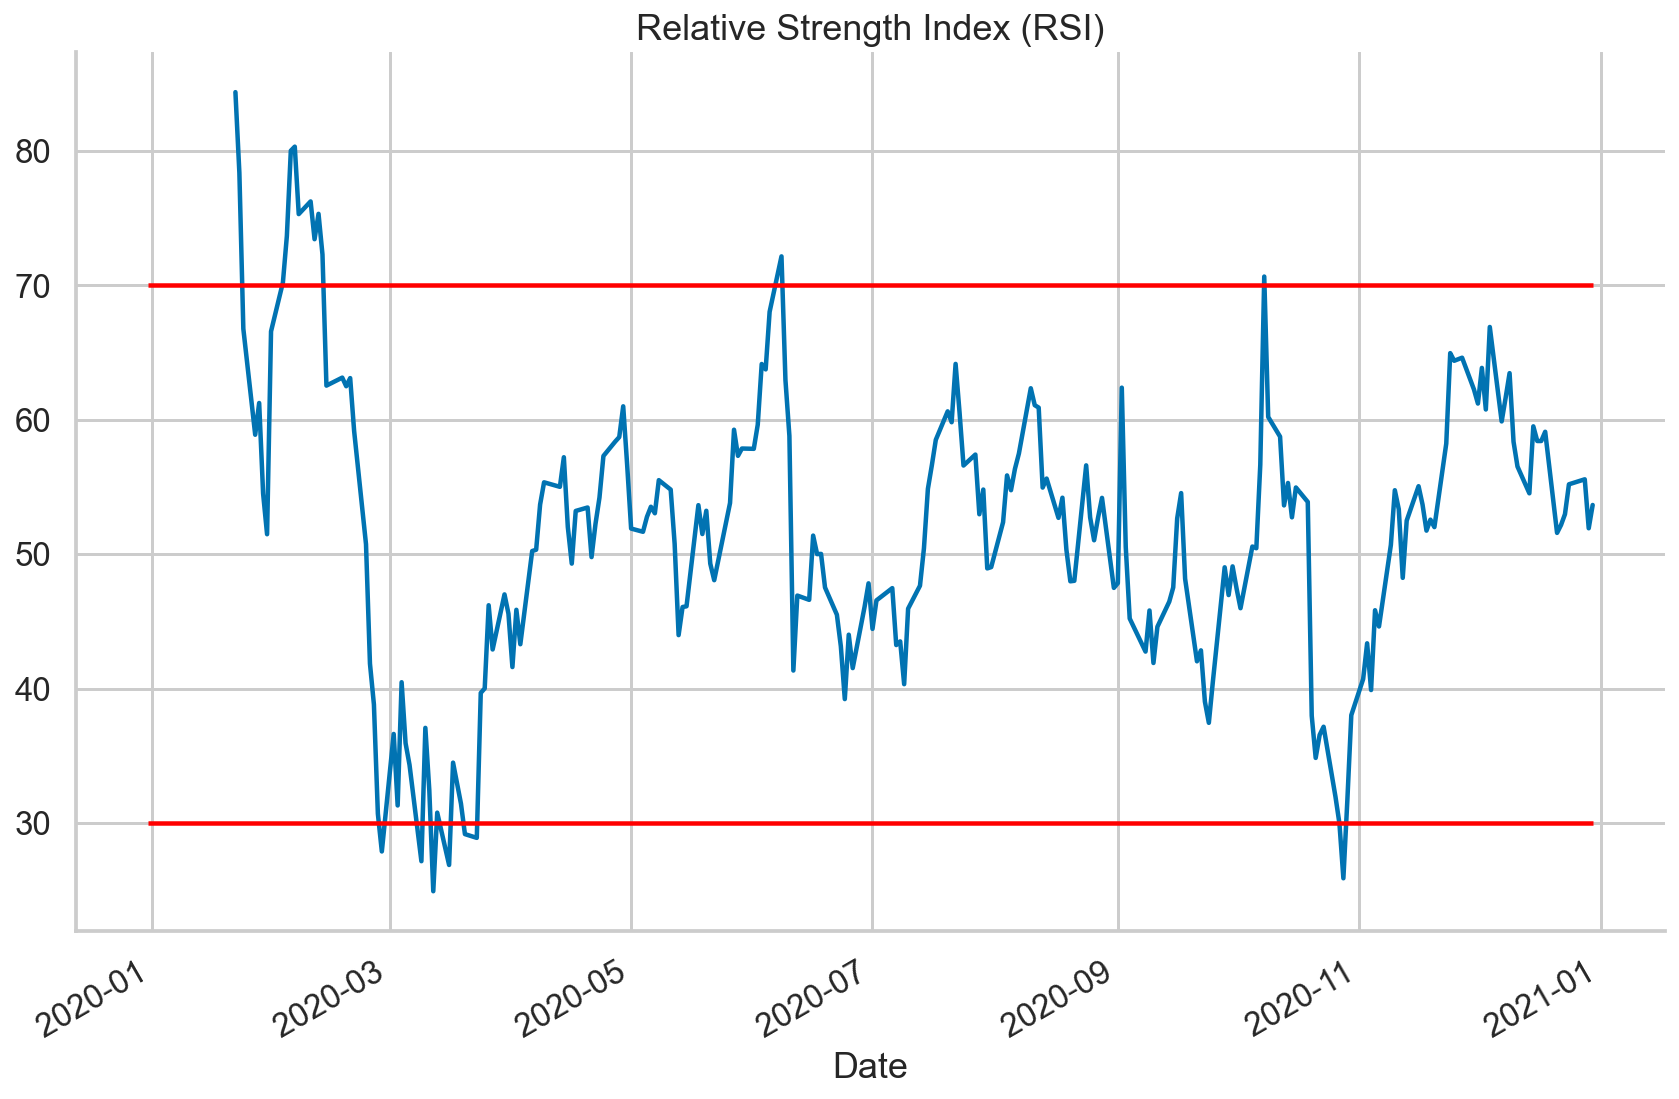

In [32]:
df["rsi"] = talib.RSI(df["Close"])

fig, ax = plt.subplots()
df["rsi"].plot(ax=ax, 
               title="Relative Strength Index (RSI)")
ax.hlines(y=30, 
          xmin=df.index.min(), 
          xmax=df.index.max(), 
          color="red")
ax.hlines(y=70, 
          xmin=df.index.min(), 
          xmax=df.index.max(), 
          color="red")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_3", dpi=200)

### 4. 이동평균수렴발산(MACD)

두 개의 지수이동평균(EMA) 간의 관계를 보여주는 모멘텀 지표입니다.
```
계산 방법:

- 빠른 EMA (일반적으로 12일) 계산
- 느린 EMA (일반적으로 26일) 계산
- MACD 선 = 빠른 EMA - 느린 EMA
- 시그널 선 = MACD 선의 9일 EMA
```

해석: MACD 선이 시그널 선을 아래에서 위로 교차할 때 매수 신호로 간주할 수 있습니다.

In [40]:
help(talib.MACD)

Help on function MACD in module talib._ta_lib:

MACD(...)
    MACD(real[, fastperiod=?, slowperiod=?, signalperiod=?])
    
    Moving Average Convergence/Divergence (Momentum Indicators)
    
    Inputs:
        real: (any ndarray)
    Parameters:
        fastperiod: 12
        slowperiod: 26
        signalperiod: 9
    Outputs:
        macd
        macdsignal
        macdhist



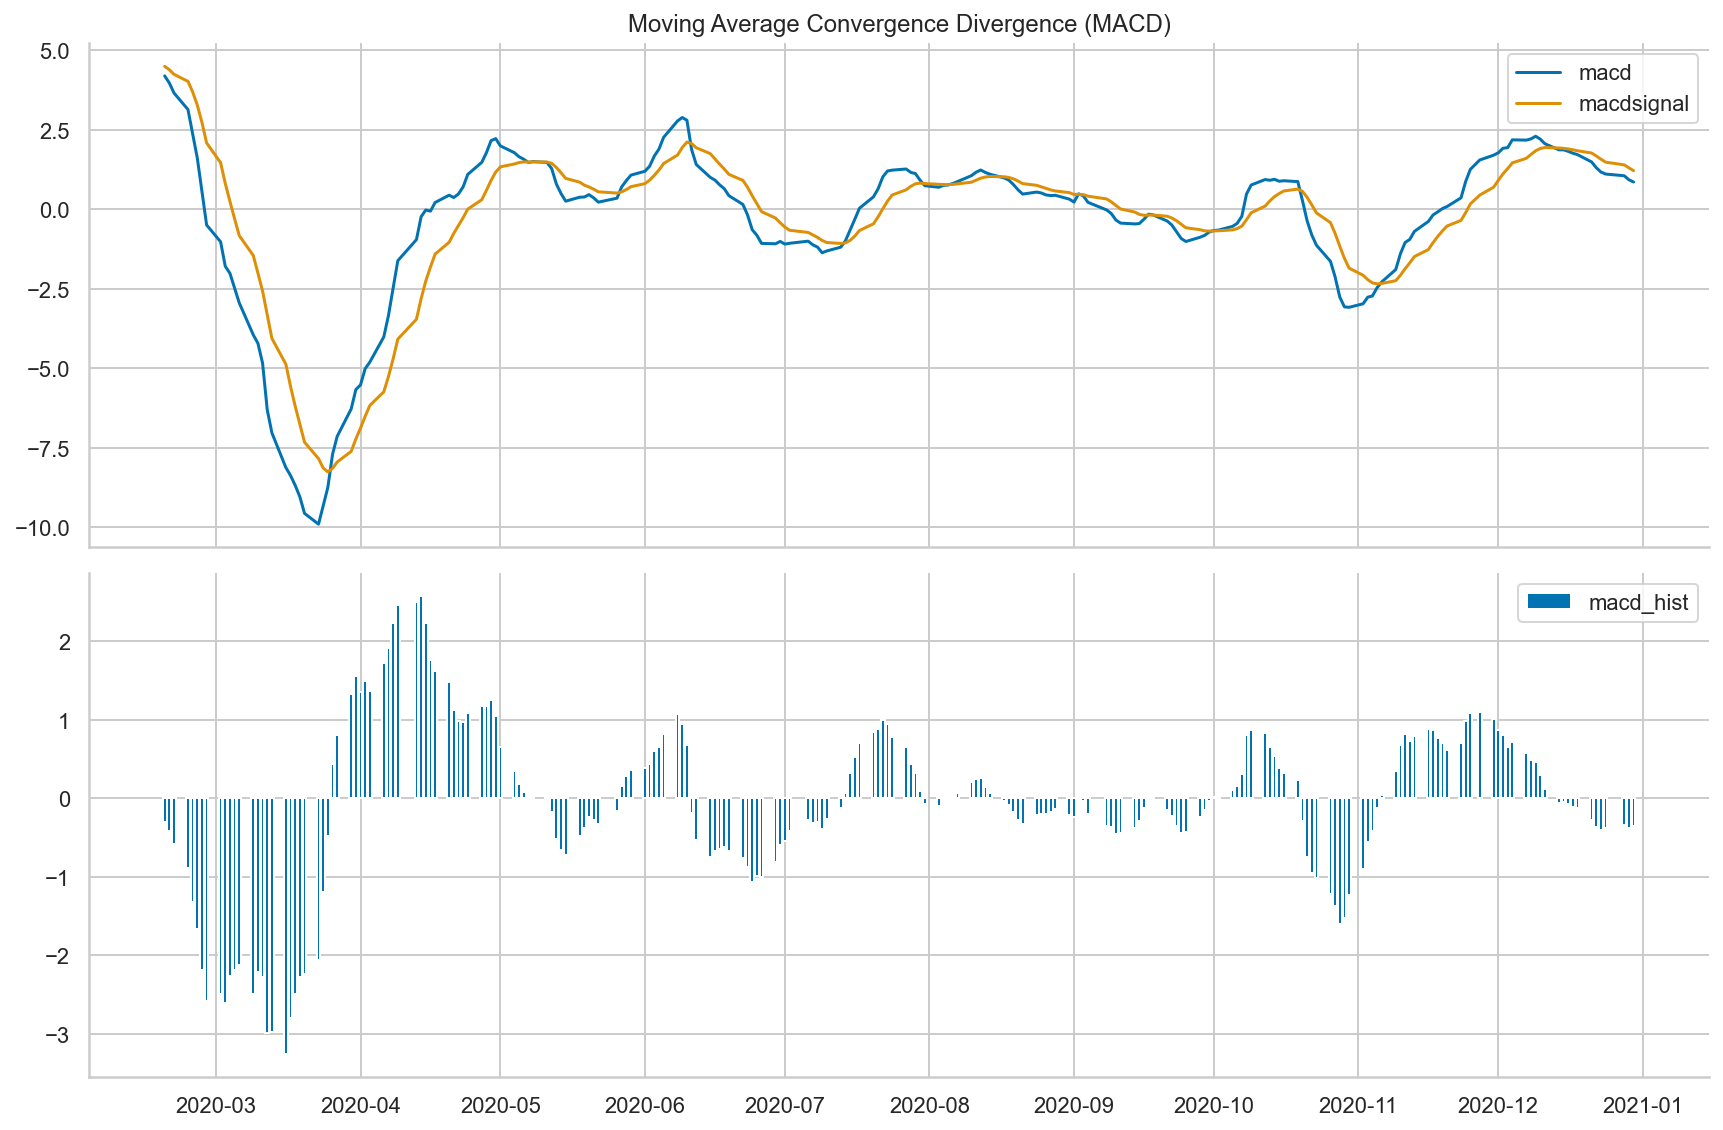

In [6]:
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(
    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
)

with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(2, 1, sharex=True)

    (
        df[["macd", "macdsignal"]].
        plot(ax=ax[0],
             title="Moving Average Convergence Divergence (MACD)")
    )
    ax[1].bar(df.index, df["macdhist"].values, label="macd_hist")
    ax[1].legend()

    sns.despine()
    plt.tight_layout()
    # plt.savefig("images/figure_5_4", dpi=200)


### 결론
모든 지표는 단독으로 사용하기보다는 여러 신호를 종합적으로 고려하여 트레이딩 결정을 내리는 것이 좋습니다. 또한 각 지표의 파라미터는 특정 목적에 맞게 조정할 수 있습니다.

In [11]:
# pip install ta
from ta import add_all_ta_features

In [12]:
df = df[["Open", "High", "Low", "Close", "Volume"]].copy()

In [17]:
df = add_all_ta_features(df, open="Open", high="High", 
                         low="Low", close="Close", 
                         volume="Volume")

In [18]:
df.shape

(252, 91)

In [19]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base

## 5.2 기술적 지표 다운받기
일부 데이터 제공업체들은 역사적 주가 데이터뿐만 아니라 미리 계산된 인기 있는 기술적 지표들도 제공합니다. 이 챕터에서는 두 가지 주요 데이터 제공업체를 다룹니다: Alpha Vantage와 Intrinio.

### 1. Alpha Vantage를 사용한 RSI 다운로드

1. Import the libraries:

In [46]:
from alpha_vantage.techindicators import TechIndicators
import os
from dotenv import load_dotenv
load_dotenv()

True

2. Instantiate the `TechIndicators` class and authenticate:

In [47]:
ta_api = TechIndicators(key="YOUR_KEY_HERE", 
                        output_format="pandas")

3. Download the RSI for IBM's stock:

In [48]:
rsi_df, rsi_meta = ta_api.get_rsi(symbol="IBM", 
                                  time_period=14)

In [49]:
display(rsi_df.head())
display(rsi_meta)

,RSI
date,
2024-09-06,64.5275
2024-09-05,70.6128
2024-09-04,76.0872
2024-09-03,72.3860
2024-08-30,75.6517


{'1: Symbol': 'IBM',
 '2: Indicator': 'Relative Strength Index (RSI)',
 '3: Last Refreshed': '2024-09-06',
 '4: Interval': 'daily',
 '5: Time Period': 14,
 '6: Series Type': 'close',
 '7: Time Zone': 'US/Eastern Time'}

메타데이터에는 요청한 주식 심볼, 지표 이름, 마지막 업데이트 날짜, 기간 등의 정보가 포함됩니다.

4. Plot the downloaded RSI:

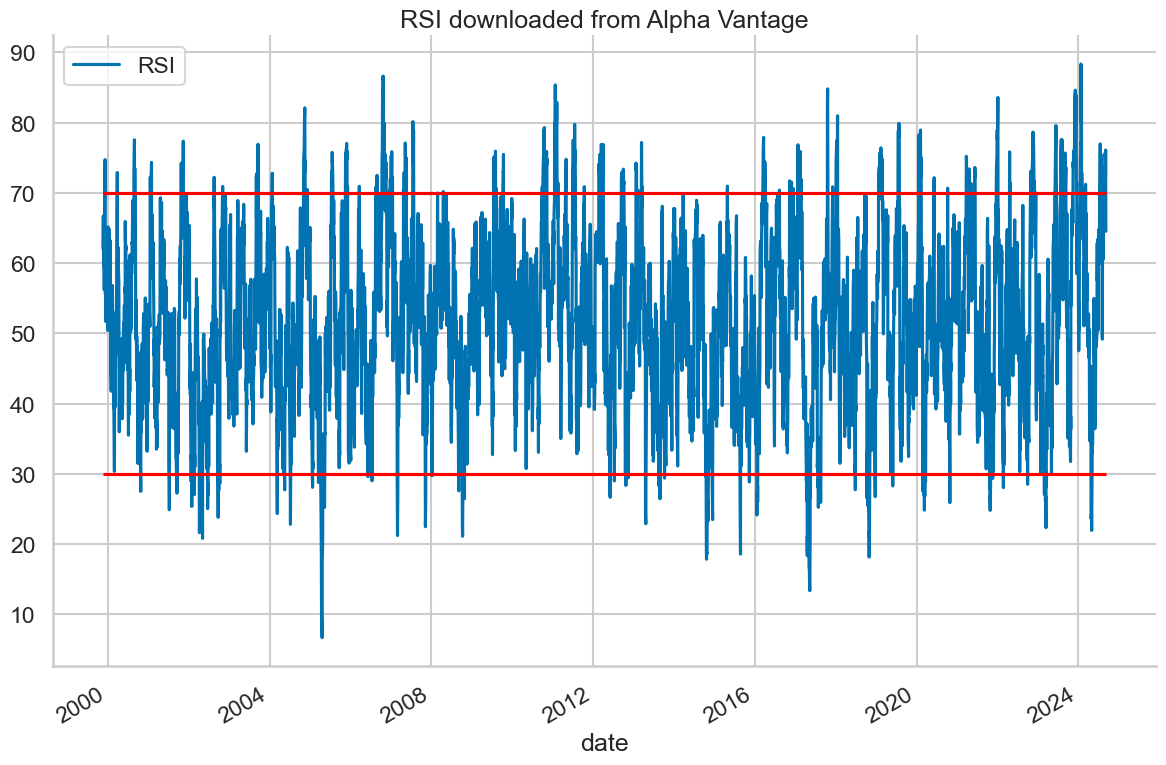

In [45]:
fig, ax = plt.subplots()
rsi_df.plot(ax=ax, 
            title="RSI downloaded from Alpha Vantage")
ax.hlines(y=30, 
          xmin=rsi_df.index.min(), 
          xmax=rsi_df.index.max(), 
          color="red")
ax.hlines(y=70, 
          xmin=rsi_df.index.min(), 
          xmax=rsi_df.index.max(), 
          color="red")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_5_5", dpi=200)

주의사항:

Alpha Vantage에서는 원하는 날짜 범위를 지정할 수 없습니다. 대신 가장 최근 데이터부터 과거 데이터까지 모두 제공합니다.
일부 지표(예: MACD)는 프리미엄 엔드포인트로, 유료 플랜 구매가 필요할 수 있습니다.

### 2.  (잘안됨. skip) intrinio를 사용한 MACD 다운로드 (잘안됨. skip)

1. Import the libraries:

In [23]:
import intrinio_sdk as intrinio
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()

True

2. Authenticate using the personal API key and select the API:

In [24]:
intrinio.ApiClient().set_api_key(os.getenv('intrinio_key'))
security_api = intrinio.SecurityApi()

3. Request the MACD for IBM's stock from 2020:

In [28]:
r = security_api.get_security_price_technicals_macd(
    identifier="IBM", 
    fast_period=10, 
    slow_period=20, 
    signal_period=9, 
    price_key="close", 
    start_date="2022-01-01", 
    end_date="2022-12-31",
    page_size=500
)

ApiException: (401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Fri, 06 Sep 2024 22:35:00 GMT', 'Content-Type': 'application/json', 'Content-Length': '104', 'Connection': 'keep-alive', 'Vary': 'Origin,Accept-Encoding'})
HTTP response body: {"human":"No active subscription(s).","message":"An active subscription is required to view this data."}


4. Convert the request's output into a `pandas` DataFrame:

In [ ]:
macd_df = (
    pd.DataFrame(r.technicals_dict)
    .sort_values("date_time")
    .set_index("date_time")
)
macd_df.index = pd.to_datetime(macd_df.index).date
macd_df

5. Plot the MACD:

In [ ]:
# with sns.plotting_context("notebook"):
    
#     fig, ax = plt.subplots(2, 1, sharex=True)

#     (
#         macd_df[["macd_line", "signal_line"]]
#         .plot(ax=ax[0], 
#               title="MACD downloaded from Intrinio")
#     )
#     ax[1].bar(df.index, macd_df["macd_histogram"].values, 
#               label="macd_hist")
#     ax[1].legend()

#     sns.despine()
#     plt.tight_layout()
#     # plt.savefig("images/figure_5_6", dpi=200)


## 5.3 candlestick patterns 인식
- 캔들스틱 패턴 인식은 기술적 분석의 중요한 부분으로, 가격 방향과 모멘텀을 결정하는 데 사용될 수 있습니다.

>  개요

- 수백 가지의 캔들스틱 패턴이 존재합니다.
- 패턴은 특정 차트 주기(일봉, 주봉 등) 내에서만 유효합니다.
- 패턴의 예측력은 완성 후 3-5개의 봉 이후 급격히 감소합니다.
- 현대 전자 거래 환경에서는 일부 패턴의 신뢰성이 떨어질 수 있습니다.

### 1. Three Line Strike로 bearish, bullish 패턴 식별
- 이 예제에서는 비트코인의 시간봉 데이터를 사용하여 Three Line Strike 패턴을 식별합니다.

In [54]:
import pandas as pd 
import yfinance as yf
import talib
import mplfinance as mpf

- Download Bitcoin's hourly prices from the last 3 months:

In [78]:
df = yf.download("BTC-USD", 
                 period="3mo",
                 interval="1h",
                 progress=False)
display(df.head())
display(df.tail())

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-06-06 23:00:00+00:00,70871.476562,70922.179688,70738.281250,70776.750000,70776.750000,0
2024-06-07 00:00:00+00:00,70772.414062,70858.304688,70744.140625,70845.835938,70845.835938,0
2024-06-07 01:00:00+00:00,70857.593750,70874.960938,70672.617188,70833.554688,70833.554688,0
2024-06-07 02:00:00+00:00,70830.859375,70843.234375,70664.125000,70805.117188,70805.117188,0
2024-06-07 03:00:00+00:00,70808.304688,70992.695312,70738.039062,70971.367188,70971.367188,91332608


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-09-06 19:00:00+00:00,53398.093750,53862.179688,53250.488281,53554.324219,53554.324219,1257418752
2024-09-06 20:00:00+00:00,53513.539062,53731.363281,52714.523438,52827.289062,52827.289062,2132758528
2024-09-06 21:00:00+00:00,52629.523438,53699.144531,52629.523438,53699.144531,53699.144531,2129387520
2024-09-06 22:00:00+00:00,53740.335938,53825.140625,53605.222656,53622.132812,53622.132812,267218944
2024-09-06 23:00:00+00:00,53625.644531,53821.894531,53602.574219,53815.308594,53815.308594,132321280


- Identify the "Three Line Strike" pattern:

In [79]:
df["3_line_strike"] = talib.CDL3LINESTRIKE(
    df["Open"], df["High"], df["Low"], df["Close"]
)
df["3_line_strike"].value_counts()

3_line_strike
 0      2193
 100      10
-100       6
Name: count, dtype: int64

-  Locate and plot the bearish pattern:

In [80]:
df[df["3_line_strike"] == -100].head().round(2)

,Open,High,Low,Close,Adj Close,Volume,3_line_strike
Datetime,,,,,,,
2024-06-30 22:00:00+00:00,61837.41,62828.79,61837.41,62799.94,62799.94,1286020096,-100
2024-07-27 02:00:00+00:00,67672.95,68046.05,67672.95,68009.23,68009.23,0,-100
2024-08-01 05:00:00+00:00,63701.34,64298.57,63584.75,64296.25,64296.25,610349056,-100
2024-08-23 00:00:00+00:00,60385.07,60932.00,60372.07,60745.88,60745.88,207886336,-100
2024-08-30 06:00:00+00:00,58779.11,59351.78,58707.62,59351.18,59351.18,0,-100


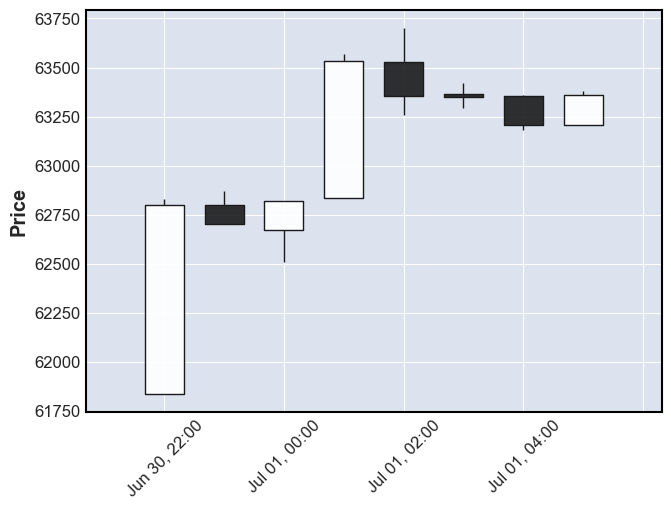

In [82]:
mpf.plot(df["2024-06-30 22:00:00+00:00":"2024-07-01 5:00:00+00:00"], 
         type="candle")

> 하락 추세에서의 패턴 (Bearish Variant):

- 연속 패턴에 속합니다.
- 3개의 연속된 하락 봉
- 4번째 봉이 3번째 봉의 저점 또는 그 아래에서 시작하지만, 상승 반전하여 첫 번째 봉의 고점 위에서 종가

5. Locate and plot the bullish pattern:

In [83]:
df[df["3_line_strike"] == 100].head().round(2)

,Open,High,Low,Close,Adj Close,Volume,3_line_strike
Datetime,,,,,,,
2024-06-19 07:00:00+00:00,65590.73,65630.92,65249.80,65304.87,65304.87,0,100
2024-06-23 20:00:00+00:00,64101.84,64109.28,63689.95,63707.69,63707.69,515943424,100
2024-06-24 09:00:00+00:00,62779.52,62779.52,61013.74,61354.39,61354.39,3735484416,100
2024-06-28 12:00:00+00:00,61594.17,61720.31,61322.69,61326.09,61326.09,471003136,100
2024-07-04 22:00:00+00:00,58461.12,58727.58,58005.12,58005.12,58005.12,237330432,100


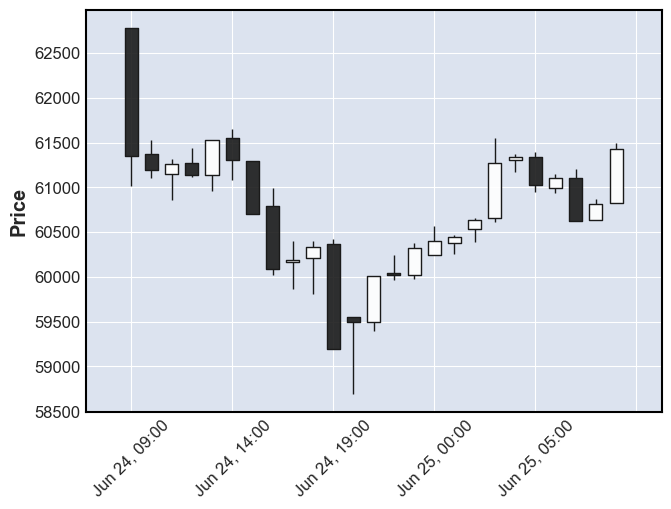

In [85]:
mpf.plot(df["2024-06-24 09:00:00+00:00":"2024-06-25 09:00:00+00:00"], 
         type="candle")

> Bullish Three Line Strike 패턴
책에서는 Bearish Three Line Strike 패턴을 주로 다뤘지만, Bullish 변형도 존재합니다. 이를 설명해드리겠습니다.
패턴 특징

- 연속 패턴에 속합니다.
- 상승 추세에서 나타납니다.
- 4개의 캔들로 구성됩니다.

패턴 형성 과정

- 첫 번째 캔들: 상승 봉
- 두 번째 캔들: 첫 번째 캔들보다 더 높은 고점을 가진 상승 봉
- 세 번째 캔들: 두 번째 캔들보다 더 높은 고점을 가진 상승 봉
- 네 번째 캔들:

세 번째 캔들의 고점이나 그 위에서 시작
하락 반전하여 첫 번째 캔들의 저점 아래에서 종가

### 2. 여러 패턴 동시 식별
여러 캔들스틱 패턴을 한 번에 식별하는 방법:

1. Get all available pattern names:

In [86]:
candle_names = talib.get_function_groups()["Pattern Recognition"]

2. Iterate over the list of patterns and try identifying them all:

In [87]:
# 모든 패턴 식별
for candle in candle_names:
    df[candle] = getattr(talib, candle)(df["Open"], df["High"], 
                                        df["Low"], df["Close"])

3. Inspect the summary statistics of the patterns:

In [30]:
# 패턴 식별 결과 요약
with pd.option_context("display.max_rows", len(candle_names)):
    display(df[candle_names].describe().transpose().round(2))

,count,mean,std,min,25%,50%,75%,max
CDL2CROWS,6454.0,-0.11,3.29,-100.0,0.0,0.0,0.0,0.0
CDL3BLACKCROWS,6454.0,-0.06,2.49,-100.0,0.0,0.0,0.0,0.0
CDL3INSIDE,6454.0,0.03,10.99,-100.0,0.0,0.0,0.0,100.0
CDL3LINESTRIKE,6454.0,0.08,6.70,-100.0,0.0,0.0,0.0,100.0
CDL3OUTSIDE,6454.0,0.26,23.39,-100.0,0.0,0.0,0.0,100.0
CDL3STARSINSOUTH,6454.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
CDL3WHITESOLDIERS,6454.0,0.19,4.31,0.0,0.0,0.0,0.0,100.0
CDLABANDONEDBABY,6454.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
CDLADVANCEBLOCK,6454.0,-1.30,11.33,-100.0,0.0,0.0,0.0,0.0
CDLBELTHOLD,6454.0,-0.20,42.63,-100.0,0.0,0.0,0.0,100.0


4. Locate and plot the "Evening Star" pattern:

In [88]:
df[df["CDLEVENINGSTAR"]  == -100].head()

,Open,High,Low,Close,Adj Close,Volume,3_line_strike,CDL2CROWS,CDL3BLACKCROWS,CDL3INSIDE,...,CDLSPINNINGTOP,CDLSTALLEDPATTERN,CDLSTICKSANDWICH,CDLTAKURI,CDLTASUKIGAP,CDLTHRUSTING,CDLTRISTAR,CDLUNIQUE3RIVER,CDLUPSIDEGAP2CROWS,CDLXSIDEGAP3METHODS
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-06-20 12:00:00+00:00,66143.406250,66264.507812,65913.156250,65949.632812,65949.632812,665890816,0,-100,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-06-25 05:00:00+00:00,61338.750000,61389.773438,60952.378906,61029.988281,61029.988281,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-06-25 16:00:00+00:00,61811.914062,61904.636719,61375.542969,61375.542969,61375.542969,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100
2024-07-02 13:00:00+00:00,62789.238281,63015.031250,62508.972656,62573.691406,62573.691406,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-07-07 00:00:00+00:00,58239.429688,58244.250000,57962.425781,57962.425781,57962.425781,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,100


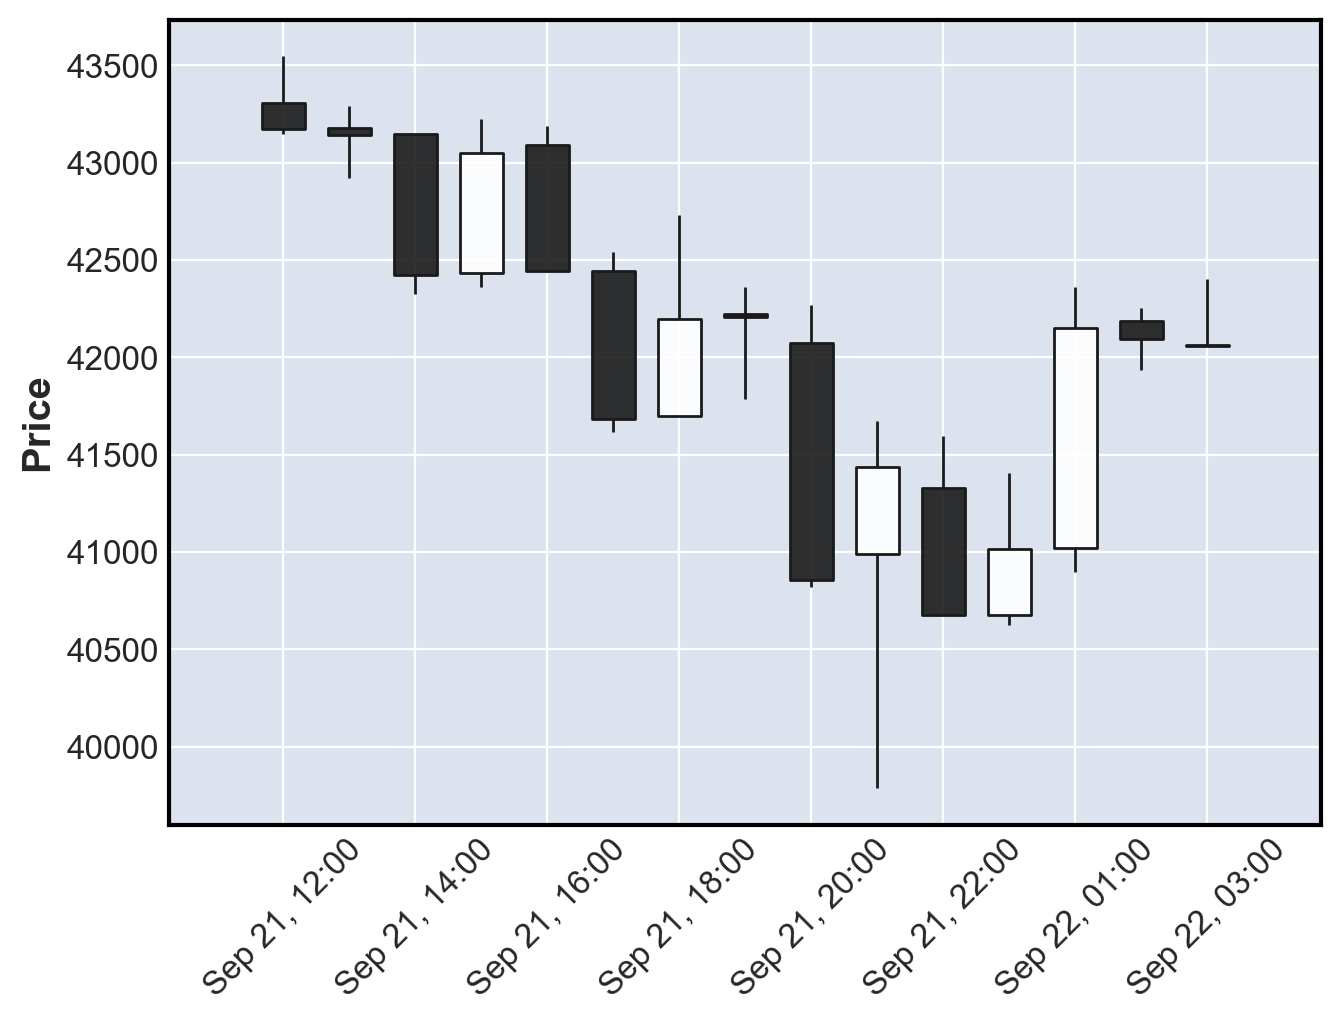

In [33]:
mpf.plot(df["2021-09-21 12:00:00":"2021-09-22 03:00:00"], type="candle")

### 결론
캔들스틱 패턴 인식은 강력한 기술적 분석 도구이지만, 다른 지표들과 함께 사용해야 합니다. 또한 현대 거래 환경에서의 한계점을 인식하고, 실제 거래에 적용할 때는 충분한 백테스팅과 검증이 필요합니다.

## 5.4 Building an interactive web app for technical analysis using Streamlit

### 개요
Streamlit은 Python으로 대화형 웹 앱을 빠르게 만들 수 있는 오픈 소스 프레임워크입니다.
프론트엔드 경험 없이도 데이터 중심의 앱을 만들 수 있습니다.


- 주요 기능
    - 데이터 로딩 및 캐싱
    - 사용자 입력 처리 (선택 상자, 슬라이더 등)
    - 데이터 시각화
    - 레이아웃 구성 (사이드바, 확장 패널 등)


- 앱 구조
    - 데이터 로딩 함수
    - 사이드바 구성 (사용자 입력)
    - 메인 화면 구성 (데이터 표시 및 차트)


- 기술적 분석 기능
    - 주가 데이터 다운로드
    - 기술적 지표 계산 및 표시 (SMA, Bollinger Bands, RSI)


- 인터랙티브 요소
    - 주식 선택
    - 날짜 범위 선택
    - 기술적 지표 파라미터 조정

### 실행 순서 (파워쉘 코드)

필요한 패키지 설치:
```powershell
pip install streamlit pandas yfinance plotly cufflinks
```

작업 디렉토리로 이동:
```powershellCopy
cd D:\drive\SelfStudy\ml4t\source\Python_for_Finance_Cookbook
```

Streamlit 앱 실행:
```powershellCopy
streamlit run technical_analysis_app.py
```
(선택사항) 특정 포트로 실행하려면:
```powershellCopy
streamlit run technical_analysis_app.py --server.port 8501
```

앱 종료:

터미널에서 Ctrl+C를 누르거나 파워쉘 창을 닫습니다.



실행 후 웹 브라우저가 자동으로 열리고 앱이 표시됩니다. 주식 선택, 날짜 범위 설정, 기술적 지표 추가 등 다양한 상호작용을 통해 기술적 분석을 수행할 수 있습니다.
이 앱은 S&P 500 구성 종목의 주가 데이터를 분석하고, 사용자가 선택한 기술적 지표를 차트에 추가할 수 있는 기능을 제공합니다. 사용자는 직관적인 인터페이스를 통해 복잡한 금융 데이터를 쉽게 탐색하고 분석할 수 있습니다.

## 5.5 Deploying the technical analysis app

### 개요

Streamlit 앱을 로컬에서 실행하는 것을 넘어 온라인으로 배포하여 언제 어디서나 접근 가능하게 만듭니다.
Streamlit Cloud를 사용하여 쉽고 빠르게 배포할 수 있습니다.


준비 사항

GitHub 계정
Streamlit Cloud 계정 (https://streamlit.io/cloud)




### 배포 과정
a. GitHub 준비:

앱 코드를 공개 GitHub 저장소에 업로드합니다.
필요한 모든 파일(앱 스크립트, requirements.txt 등)을 포함해야 합니다.

b. Streamlit Cloud 설정:

Streamlit Cloud에 로그인합니다.
"New app" 버튼을 클릭합니다.
GitHub 저장소, 브랜치, 파일 경로를 지정합니다.

c. 배포:

"Deploy" 버튼을 클릭하여 앱을 배포합니다.
Streamlit Cloud가 자동으로 앱을 빌드하고 호스팅합니다.


주요 고려사항

requirements.txt: 필요한 모든 패키지를 명시해야 합니다.
보안: API 키나 비밀 정보는 Streamlit의 비밀 관리 기능을 사용하여 안전하게 저장해야 합니다.
리소스 제한: Streamlit Cloud의 무료 티어는 제한된 컴퓨팅 리소스를 제공합니다.


배포 후 관리

앱 모니터링: Streamlit Cloud 대시보드에서 앱 상태와 사용량을 확인할 수 있습니다.
업데이트: GitHub 저장소에 변경사항을 push하면 자동으로 앱이 업데이트됩니다.


대안적 배포 방법

Heroku: 더 많은 커스터마이징이 필요한 경우 사용할 수 있습니다.
AWS, Google Cloud, Azure: 대규모 앱이나 기업용 솔루션에 적합합니다.


장점

쉬운 배포 과정
자동 업데이트
SSL 인증서 자동 관리
사용자 인증 옵션 제공


단점

무료 티어의 제한된 리소스
고급 커스터마이징의 제한



이렇게 배포된 앱은 URL을 통해 전 세계 어디서나 접근 가능하며, 사용자들에게 실시간으로 기술적 분석 도구를 제공할 수 있습니다. 지속적인 관리와 업데이트를 통해 앱의 기능을 개선하고 사용자 경험을 향상시킬 수 있습니다.